# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:10<00:00, 905754.52it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 134526.31it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1268265.79it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2823555.47it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

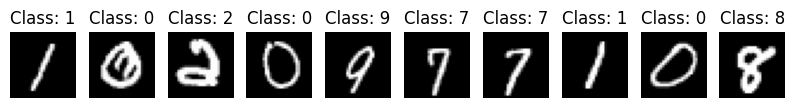

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [51]:
linear_model = LinearClassifier().to(device)
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [52]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size = batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size)

In [53]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model = model.to(device)
    model.train() # turns the tensor's gradient tracking on.
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward() #this writes the partial derivatives into the weights of the model.

        # take one step with these gradients
        optimizer.step() # weights of the model were registered to the optimizer at initialization.

        # resets the gradients
        optimizer.zero_grad() #deletes the gradients from the previous steps from the weight tensors.

In [55]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training, also saves memory.
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [56]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.50193310769399, accuracy: 87.62291666666667
Epoch 0: val. loss: 0.4941748536013542, val. accuracy: 87.71666666666667
Epoch 1: training loss: 0.421704945286115, accuracy: 88.99583333333332
Epoch 1: val. loss: 0.4124016416199664, val. accuracy: 88.86666666666667
Epoch 2: training loss: 0.3877410971721013, accuracy: 89.70833333333333
Epoch 2: val. loss: 0.3778895878411354, val. accuracy: 89.54166666666666
Epoch 3: training loss: 0.36776589588324227, accuracy: 90.08541666666666
Epoch 3: val. loss: 0.35774971164287406, val. accuracy: 89.93333333333334
Epoch 4: training loss: 0.35417557203769684, accuracy: 90.42708333333334
Epoch 4: val. loss: 0.34417777556054135, val. accuracy: 90.3
CPU times: user 58 s, sys: 160 ms, total: 58.2 s
Wall time: 1min 3s


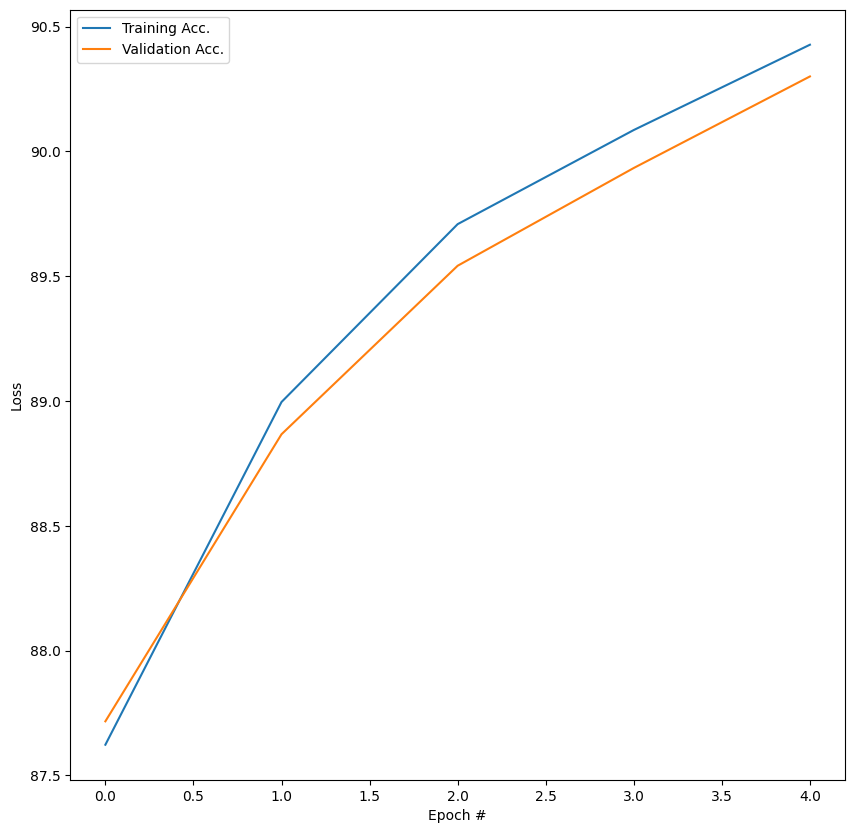

In [57]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

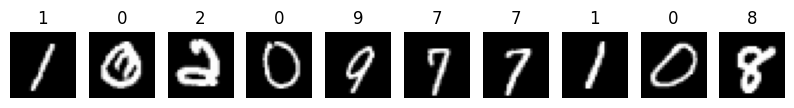

In [63]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model = linear_model.to(device)
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0].to(device))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [64]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [65]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3326, test accuracy: 90.83%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [66]:
def show_failures(model, dataloader, maxtoshow=10):
    model = model.to(device)
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0].to(device))
    predictions = predictions.to('cpu')

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


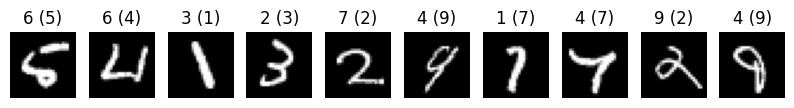

In [67]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [68]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [69]:
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [70]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.9303450252215067, accuracy: 72.35416666666666
Epoch 0: val. loss: 0.9224976117306567, val. accuracy: 72.78333333333333
Epoch 1: training loss: 0.42803972971439364, accuracy: 87.89166666666667
Epoch 1: val. loss: 0.4235679504085094, val. accuracy: 87.925
Epoch 2: training loss: 0.30847356681029003, accuracy: 91.11666666666667
Epoch 2: val. loss: 0.30421148193009356, val. accuracy: 90.95833333333333
Epoch 3: training loss: 0.24953055616219838, accuracy: 92.79375
Epoch 3: val. loss: 0.24841112976378582, val. accuracy: 92.61666666666667
Epoch 4: training loss: 0.20597016141812008, accuracy: 94.02916666666667
Epoch 4: val. loss: 0.20737243990631812, val. accuracy: 93.78333333333333
CPU times: user 57.4 s, sys: 191 ms, total: 57.6 s
Wall time: 59.3 s


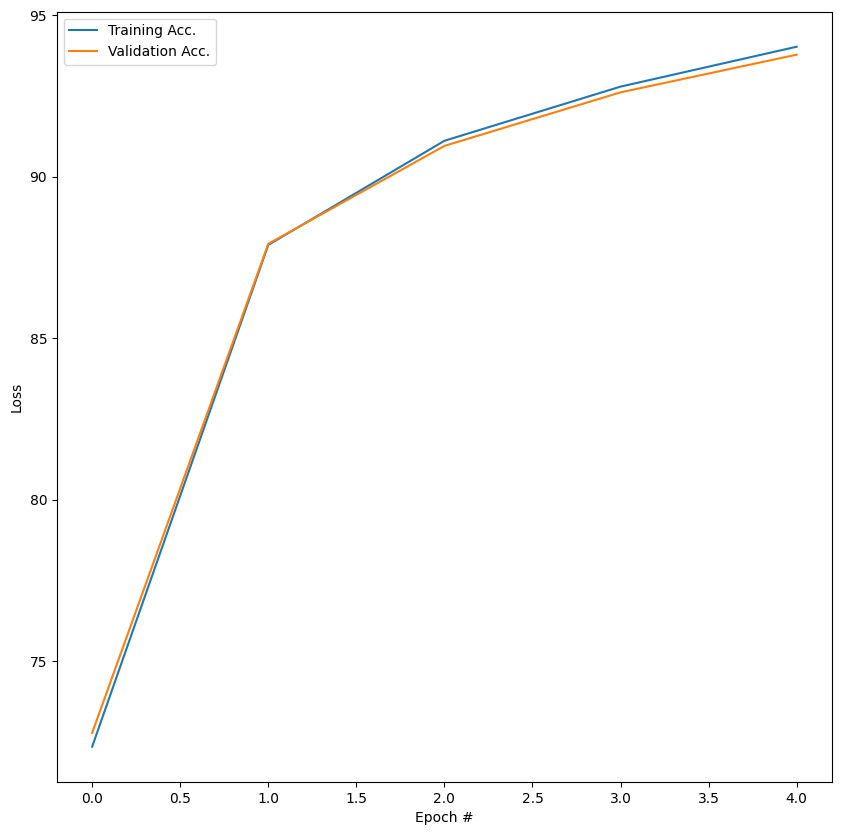

In [71]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


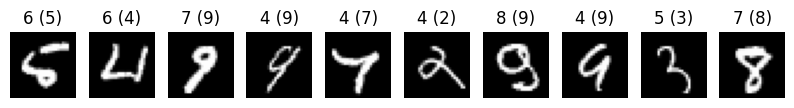

In [72]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

#Ozan Gokdemir's Homework 2 Starts Here

In [86]:
# Let's write some helper functions to avoid code repetition during experiments.

def get_dataloaders(train_data, val_data, batch_size):
    """
    Returns train and validation dataloaders given a batch size and dataset.

    Parameters
    ----------
    train_data : torch.utils.data.Dataset
        Training dataset.
    val_data : torch.utils.data.Dataset
        Validation dataset.
    batch_size : int
        Batch size.

    Returns
    -------
    train_dataloader : torch.utils.data.DataLoader
        Training dataloader.
    val_dataloader : torch.utils.data.DataLoader
        Validation dataloader.
    """

    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size = batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size)
    return train_dataloader, val_dataloader

def train_model(epochs, train_dataloader, val_dataloader, model, loss_fn, optimizer):
    """
    Trains a model for a given number of epochs.

    Parameters
    ----------
    epochs : int
        Number of epochs.
    train_dataloader : torch.utils.data.DataLoader
        Training dataloader.
    val_dataloader : torch.utils.data.DataLoader
        Validation dataloader.
    model : torch.nn.Module
        Model to train.
    loss_fn : torch.nn.Module
        Loss function.
    optimizer : torch.optim.Optimizer
        Optimizer.

    Returns
    -------
    train_acc_all : list
        Training accuracy for each epoch.
    val_acc_all : list
        Validation accuracy for each epoch.
    """

    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    return train_acc_all, val_acc_all


def plot_training_run(train_acc_logs, val_acc_logs):
    """
    Plots the training and validation accuracy for a given number of epochs.

    Parameters
    ----------
    train_acc_logs : list
        Training accuracy for each epoch.
    val_acc_logs : list
        Validation accuracy for each epoch.
    """
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()

## Part 1: Batch Size Analysis

Keeping the model architecture, learning rates, and the activation function the same. I will only vary the batch sizes of the *nonlinear_model (above)* from 32 to 512.

### Batch size: 32

Epoch 0: training loss: 0.2773101425357163, accuracy: 91.92916666666666
Epoch 0: val. loss: 0.2685063028136889, val. accuracy: 91.79166666666667
Epoch 1: training loss: 0.16796483897604048, accuracy: 95.09375
Epoch 1: val. loss: 0.1723906624118487, val. accuracy: 94.81666666666668
Epoch 2: training loss: 0.14322333350280922, accuracy: 95.70833333333333
Epoch 2: val. loss: 0.15241320350890358, val. accuracy: 95.39999999999999
Epoch 3: training loss: 0.12082201203129565, accuracy: 96.52083333333333
Epoch 3: val. loss: 0.13626476764306425, val. accuracy: 95.80833333333332
Epoch 4: training loss: 0.10453342750738374, accuracy: 96.87291666666667
Epoch 4: val. loss: 0.1225349111041675, val. accuracy: 96.39999999999999


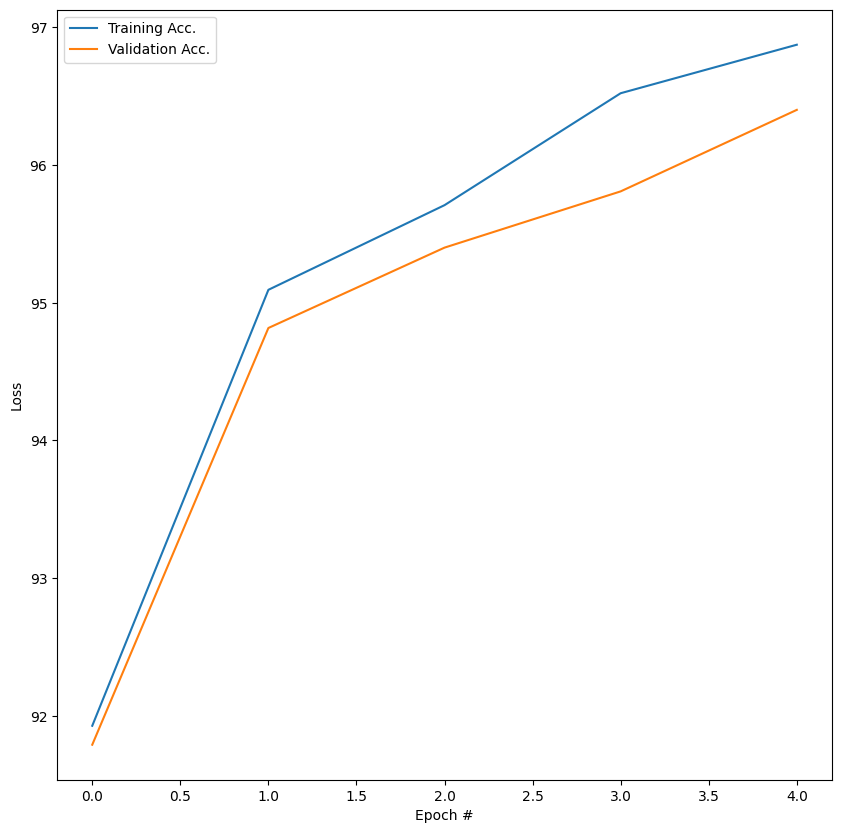

In [87]:
batch_size = 32
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Batch size: 64

Epoch 0: training loss: 0.4277527681986491, accuracy: 87.64791666666667
Epoch 0: val. loss: 0.4207784355954921, val. accuracy: 87.375
Epoch 1: training loss: 0.2595625764131546, accuracy: 92.44791666666666
Epoch 1: val. loss: 0.25553577076247397, val. accuracy: 92.34166666666667
Epoch 2: training loss: 0.19498125192523003, accuracy: 94.43125
Epoch 2: val. loss: 0.19402482001943158, val. accuracy: 94.27499999999999
Epoch 3: training loss: 0.15620936571309965, accuracy: 95.45625
Epoch 3: val. loss: 0.1627292917110026, val. accuracy: 95.16666666666667
Epoch 4: training loss: 0.13298424618939558, accuracy: 96.125
Epoch 4: val. loss: 0.1457820336948684, val. accuracy: 95.675


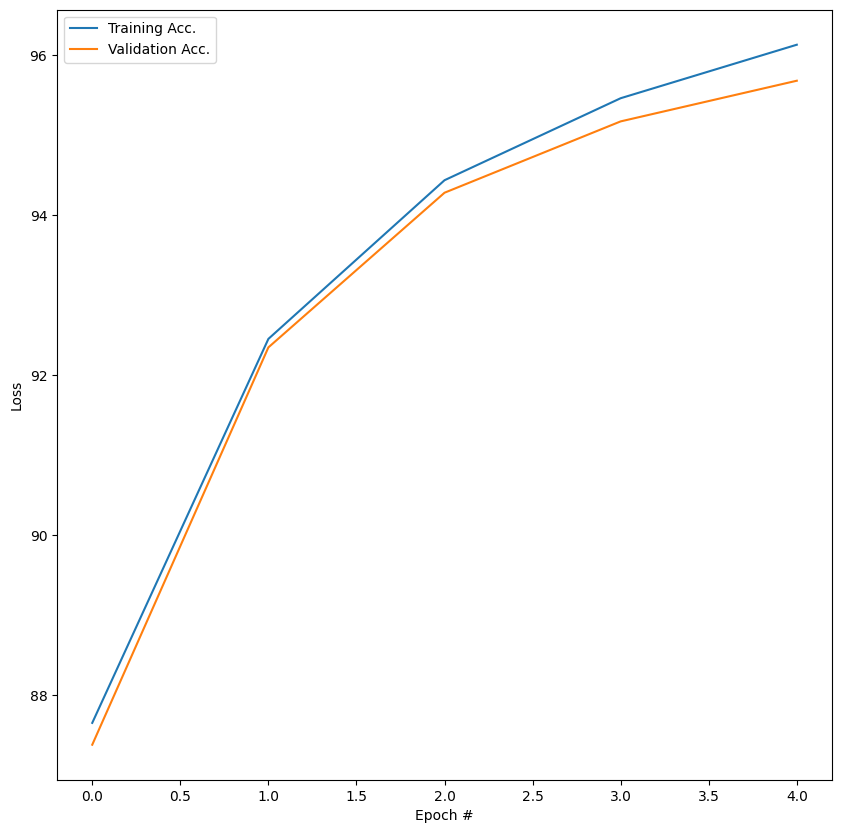

In [88]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Batch size: 128

Epoch 0: training loss: 0.8083776289621989, accuracy: 75.96875
Epoch 0: val. loss: 0.8009173223312865, val. accuracy: 75.20833333333333
Epoch 1: training loss: 0.40753335642814636, accuracy: 88.26875
Epoch 1: val. loss: 0.39718718065860426, val. accuracy: 88.33333333333333
Epoch 2: training loss: 0.309288304567337, accuracy: 91.14583333333334
Epoch 2: val. loss: 0.3018523709888154, val. accuracy: 91.125
Epoch 3: training loss: 0.25482309182484947, accuracy: 92.69583333333333
Epoch 3: val. loss: 0.2506088808654471, val. accuracy: 92.65
Epoch 4: training loss: 0.2168598222732544, accuracy: 93.67708333333333
Epoch 4: val. loss: 0.21623263777570523, val. accuracy: 93.625


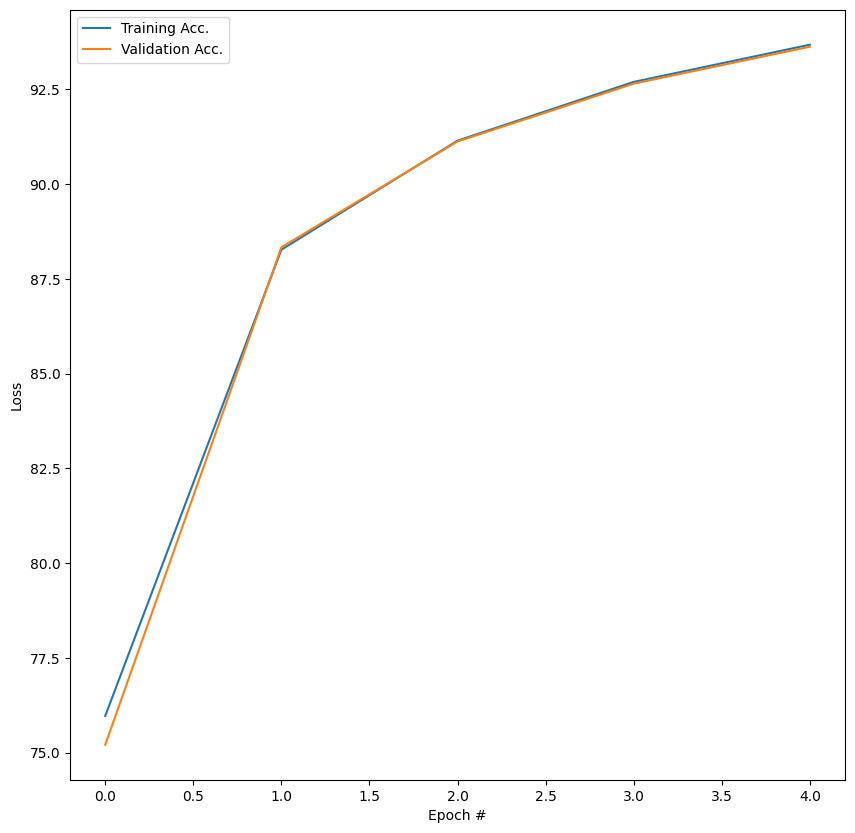

In [89]:
batch_size = 128
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Batch size: 256

Epoch 0: training loss: 1.984291155921652, accuracy: 35.08541666666667
Epoch 0: val. loss: 1.984928252849173, val. accuracy: 34.71666666666667
Epoch 1: training loss: 0.6979277723647178, accuracy: 80.0875
Epoch 1: val. loss: 0.6918888675405624, val. accuracy: 80.39166666666667
Epoch 2: training loss: 0.4662057167672096, accuracy: 86.9375
Epoch 2: val. loss: 0.4600999241179608, val. accuracy: 86.76666666666667
Epoch 3: training loss: 0.3928911508397853, accuracy: 88.89166666666667
Epoch 3: val. loss: 0.38647328095233185, val. accuracy: 88.53333333333333
Epoch 4: training loss: 0.3304403880016601, accuracy: 90.56875
Epoch 4: val. loss: 0.323591170792884, val. accuracy: 90.55833333333332


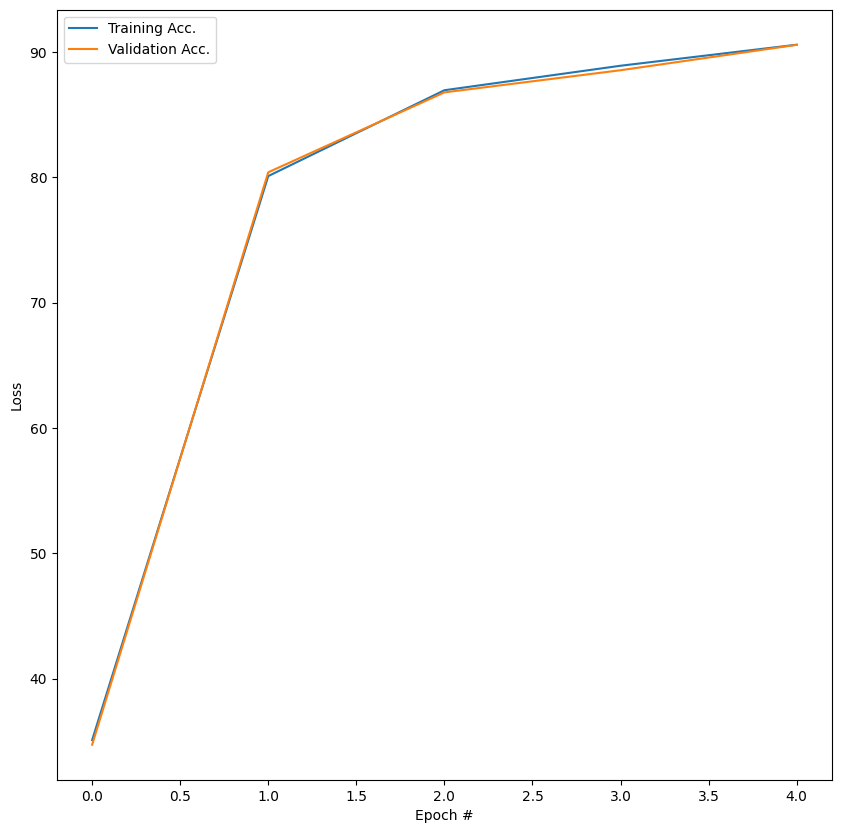

In [90]:
batch_size = 256
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Batch Size: 512

Epoch 0: training loss: 2.272351901581947, accuracy: 19.38125
Epoch 0: val. loss: 2.2716343303521476, val. accuracy: 20.008333333333333
Epoch 1: training loss: 2.037768499648317, accuracy: 41.733333333333334
Epoch 1: val. loss: 2.036327371994654, val. accuracy: 41.56666666666667
Epoch 2: training loss: 1.2816431420914671, accuracy: 72.28125
Epoch 2: val. loss: 1.2774994323650997, val. accuracy: 71.93333333333334
Epoch 3: training loss: 0.7166705245667315, accuracy: 80.12916666666666
Epoch 3: val. loss: 0.7087957213322321, val. accuracy: 79.83333333333333
Epoch 4: training loss: 0.5625233349013836, accuracy: 84.19375
Epoch 4: val. loss: 0.5540258549153805, val. accuracy: 83.98333333333333


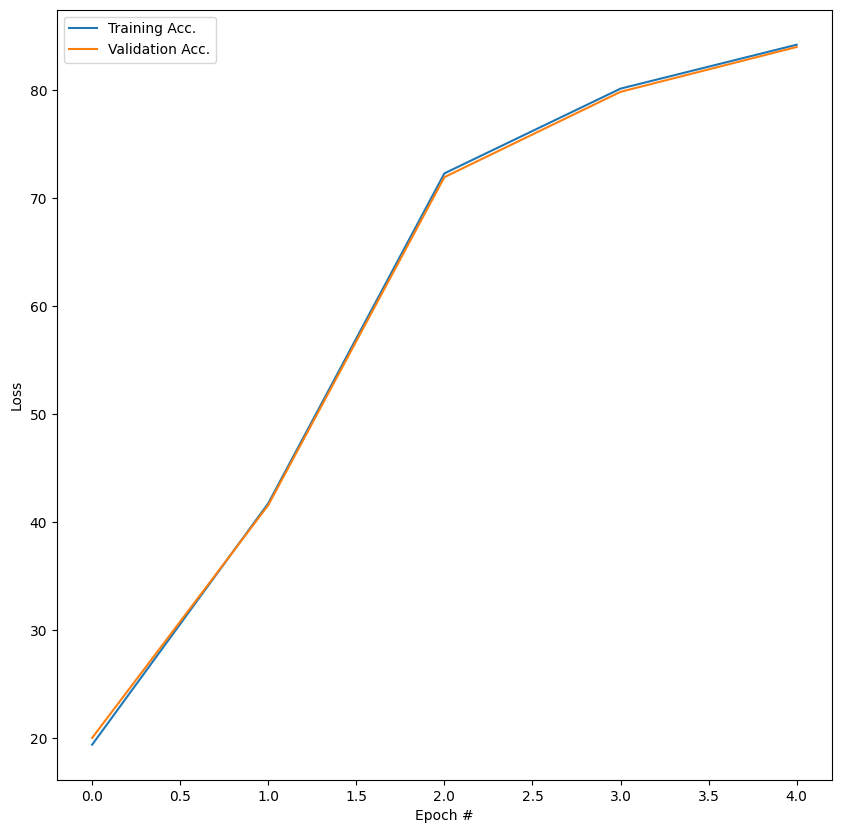

In [91]:
batch_size = 512
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Part 2: Learning Rate Analysis

From Part 1, it appears that the batch size of 64 yields the best results. Therefore, for this analysis I will keep the batch size fixed at 64. Optimizer will still be SGD. I will experiment will learning rates of 5e-1, 5e-2, 5e-3 and 5e-4

### Learning Rate: 5e-1 (0.5)

Epoch 0: training loss: 0.1982975862175226, accuracy: 94.08125000000001
Epoch 0: val. loss: 0.20220649579262479, val. accuracy: 93.875
Epoch 1: training loss: 0.14631279672433933, accuracy: 95.55833333333334
Epoch 1: val. loss: 0.15328446119785943, val. accuracy: 95.45833333333333
Epoch 2: training loss: 0.13329095031196872, accuracy: 95.97708333333334
Epoch 2: val. loss: 0.15231655936371138, val. accuracy: 95.60833333333333
Epoch 3: training loss: 0.10827697267755866, accuracy: 96.68124999999999
Epoch 3: val. loss: 0.12640912502389798, val. accuracy: 96.375
Epoch 4: training loss: 0.0901490044076927, accuracy: 97.27291666666666
Epoch 4: val. loss: 0.12042083098315337, val. accuracy: 96.35000000000001


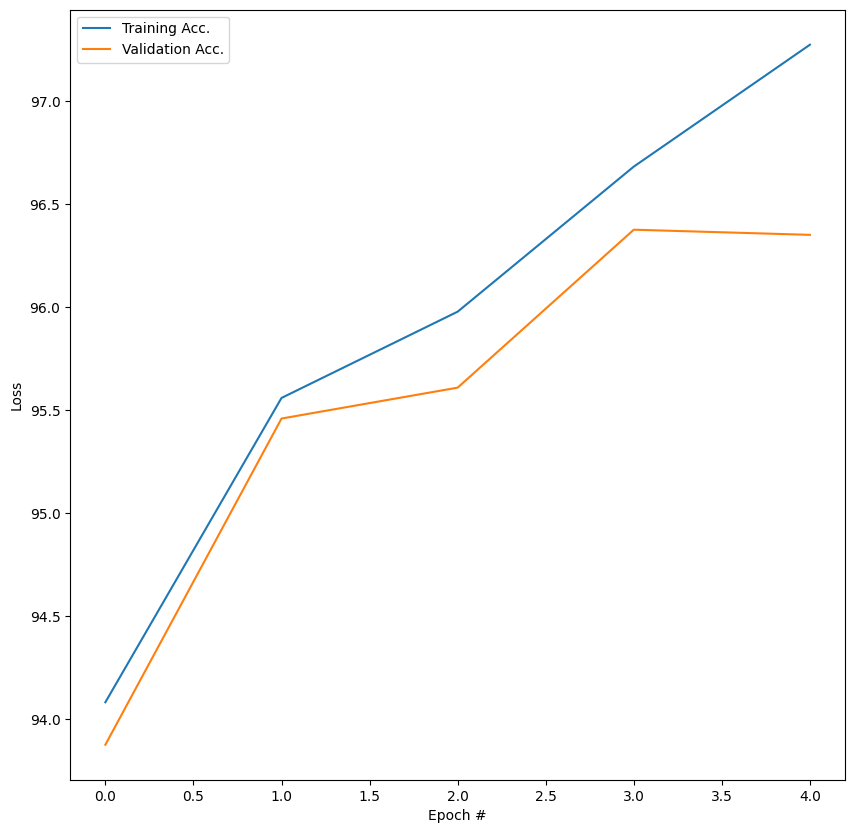

In [92]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=5e-1)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Learning Rate: 5e-2 (0.05)

Epoch 0: training loss: 0.3866896005272865, accuracy: 88.83125
Epoch 0: val. loss: 0.377254760566544, val. accuracy: 88.91666666666667
Epoch 1: training loss: 0.2500153248111407, accuracy: 92.82083333333333
Epoch 1: val. loss: 0.24564910715723293, val. accuracy: 92.66666666666666
Epoch 2: training loss: 0.18385717142124972, accuracy: 94.7125
Epoch 2: val. loss: 0.1865073984013276, val. accuracy: 94.58333333333333
Epoch 3: training loss: 0.15570350726445517, accuracy: 95.40833333333333
Epoch 3: val. loss: 0.1628864680198913, val. accuracy: 95.075
Epoch 4: training loss: 0.12993189736207325, accuracy: 96.2125
Epoch 4: val. loss: 0.14399588463748705, val. accuracy: 95.68333333333334


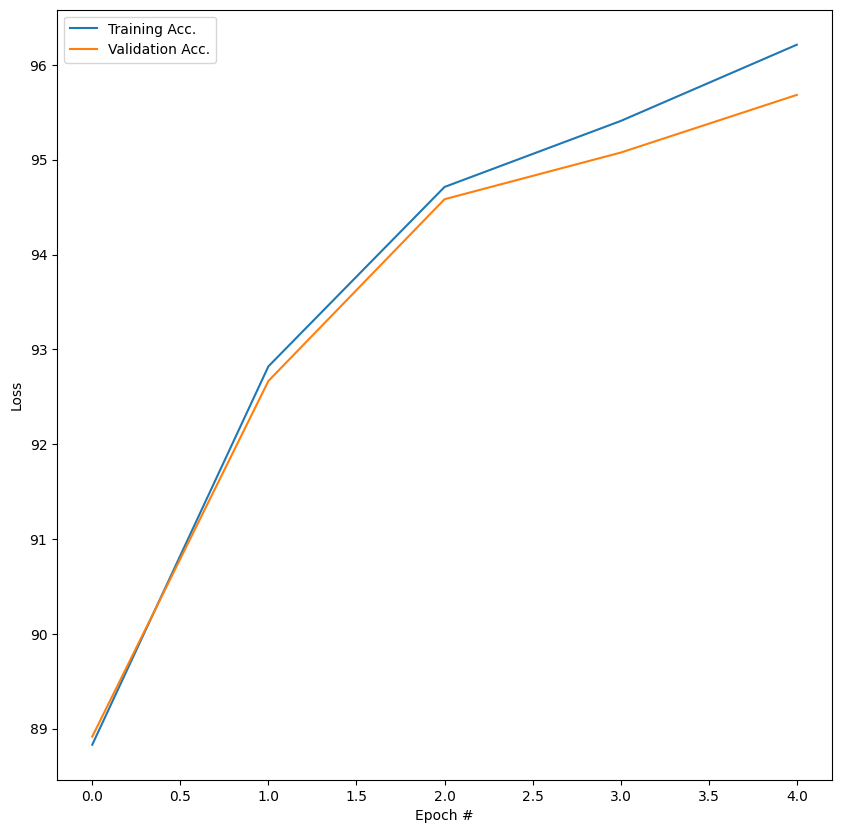

In [93]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=5e-2)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Learning Rate: 5e-3 (0.005)

Epoch 0: training loss: 2.2899205513000487, accuracy: 10.604166666666668
Epoch 0: val. loss: 2.289634198584455, val. accuracy: 10.525
Epoch 1: training loss: 2.2421319885253905, accuracy: 43.53333333333333
Epoch 1: val. loss: 2.241822668846617, val. accuracy: 43.90833333333333
Epoch 2: training loss: 1.947284598350525, accuracy: 34.329166666666666
Epoch 2: val. loss: 1.945844864591639, val. accuracy: 34.599999999999994
Epoch 3: training loss: 1.2860135280291238, accuracy: 68.13333333333334
Epoch 3: val. loss: 1.2775013776535684, val. accuracy: 68.55833333333334
Epoch 4: training loss: 0.7909518767197927, accuracy: 78.49166666666667
Epoch 4: val. loss: 0.7808427652145954, val. accuracy: 78.23333333333333


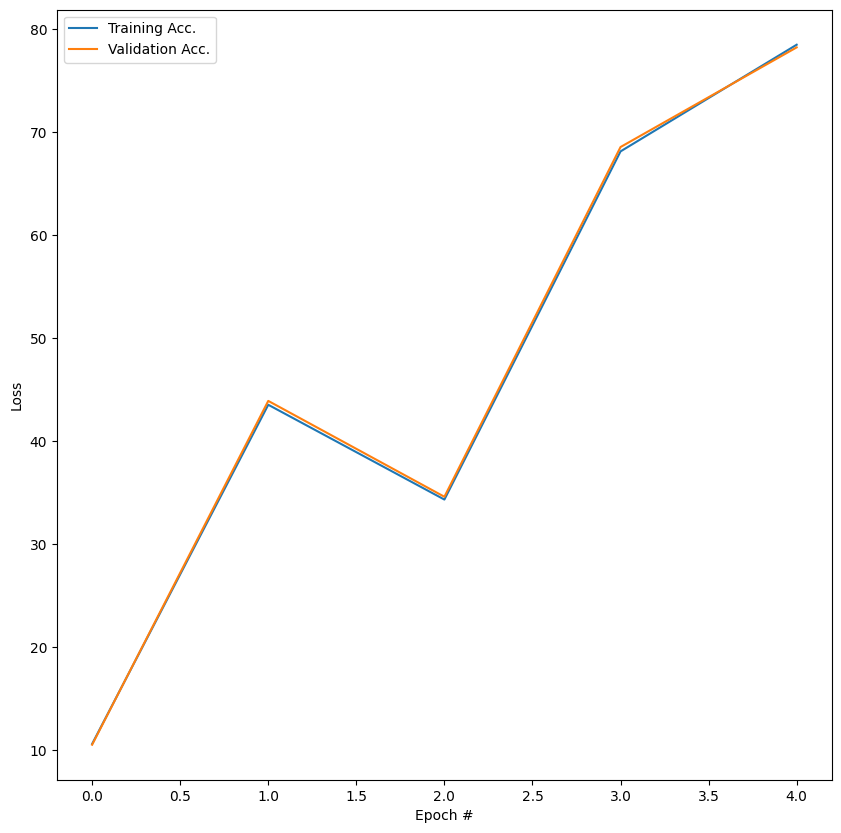

In [94]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=5e-3)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### Learning Rate: 5e-4 (0.0005)

Epoch 0: training loss: 2.3023791399002076, accuracy: 14.66875
Epoch 0: val. loss: 2.302558848198424, val. accuracy: 14.708333333333334
Epoch 1: training loss: 2.300318064689636, accuracy: 18.18541666666667
Epoch 1: val. loss: 2.300451881073891, val. accuracy: 18.025
Epoch 2: training loss: 2.298303978919983, accuracy: 19.610416666666666
Epoch 2: val. loss: 2.298389496955466, val. accuracy: 19.241666666666667
Epoch 3: training loss: 2.29626487827301, accuracy: 19.714583333333334
Epoch 3: val. loss: 2.296299410627243, val. accuracy: 19.6
Epoch 4: training loss: 2.2941214377085366, accuracy: 19.614583333333332
Epoch 4: val. loss: 2.2941044492924467, val. accuracy: 19.525000000000002


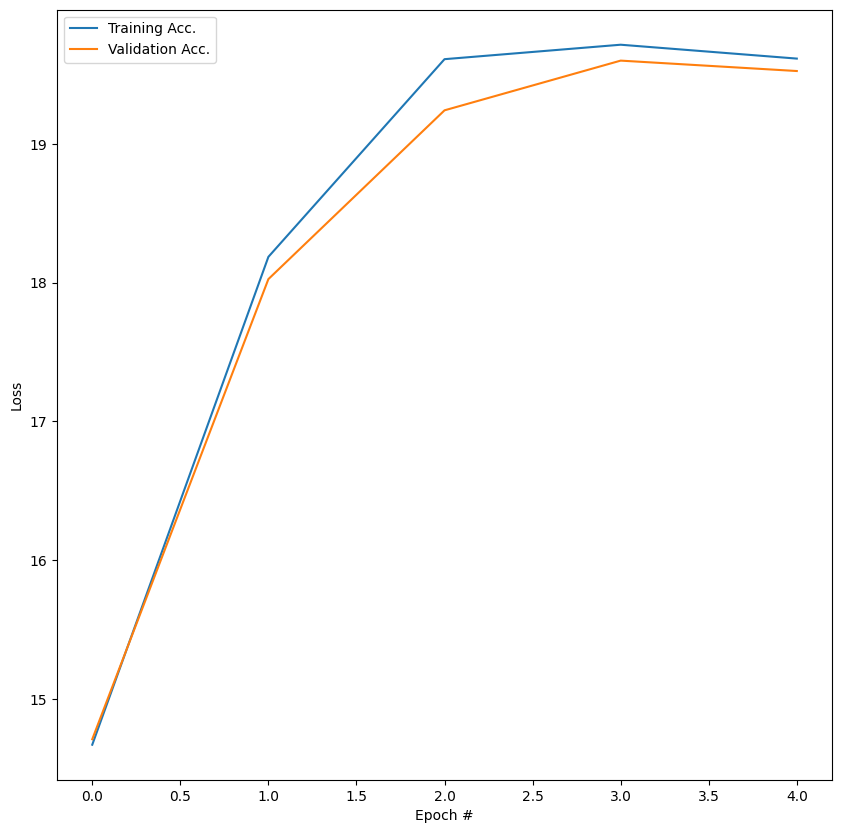

In [95]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=5e-4)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

## Part 3: Optimizer

Based on the analysis above:
* We found in Part 1 that optimal batch size is 64
* We found in Part 2 that learning rate of 5e-2 offers the most stable training run for SGD. However, for the optimizers we will explore below, we should use a more conversative learning rate. Therefore, we will try 5e-3

Therefore, for this final part. We will train our models with Batch size = 64 and learning rate = 5e-2. We will explore the following optimizers:

* Adam
* AdamW (separates the weight decay term from weight optimization)
* NAdam (Nesterov Accelerated ADAM)
* RMSProp
* AdaGrad (Adaptive Gradient)


### Adam Optimizer

Epoch 0: training loss: 0.1680849348480503, accuracy: 94.99583333333334
Epoch 0: val. loss: 0.1782088847533661, val. accuracy: 94.49166666666666
Epoch 1: training loss: 0.12770428484802446, accuracy: 96.11874999999999
Epoch 1: val. loss: 0.14982232245359015, val. accuracy: 95.45
Epoch 2: training loss: 0.11213331168393294, accuracy: 96.65416666666667
Epoch 2: val. loss: 0.13842610827587704, val. accuracy: 95.875
Epoch 3: training loss: 0.10919641009221474, accuracy: 96.78333333333333
Epoch 3: val. loss: 0.1469376502518958, val. accuracy: 95.7
Epoch 4: training loss: 0.10418992241968711, accuracy: 96.88333333333333
Epoch 4: val. loss: 0.14271869188907774, val. accuracy: 95.86666666666666


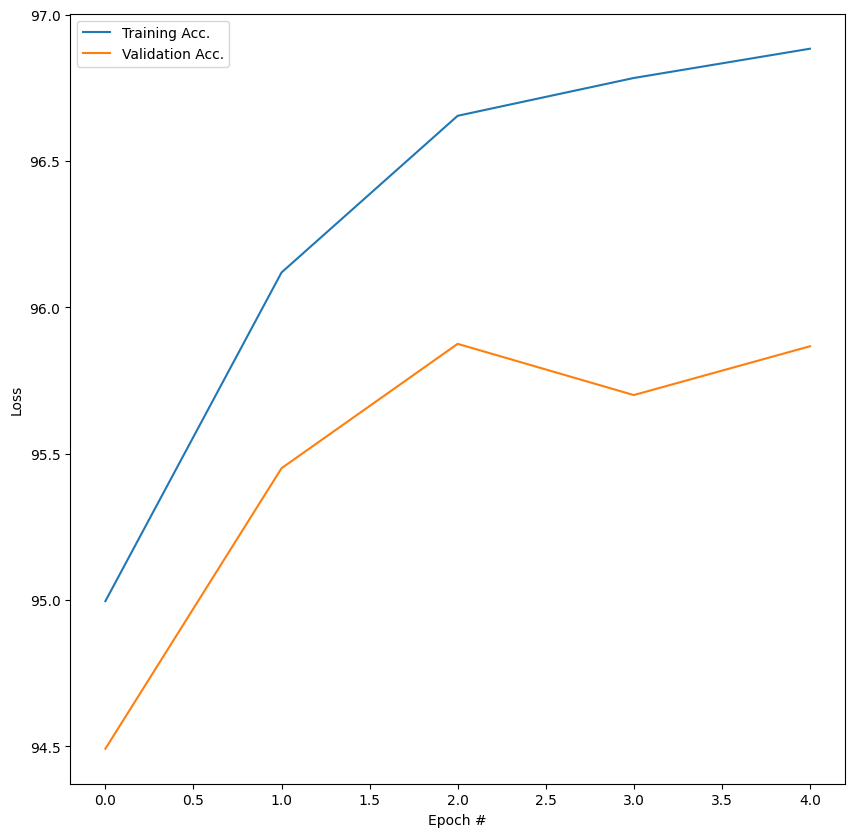

In [101]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=5e-3)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

# AdamW Optimizer

Epoch 0: training loss: 0.1919224104185899, accuracy: 94.24166666666667
Epoch 0: val. loss: 0.19920265993618586, val. accuracy: 93.95
Epoch 1: training loss: 0.13738312408079703, accuracy: 95.85625
Epoch 1: val. loss: 0.15431606973164735, val. accuracy: 95.13333333333334
Epoch 2: training loss: 0.12837369619806607, accuracy: 96.17708333333333
Epoch 2: val. loss: 0.1507470936296468, val. accuracy: 95.475
Epoch 3: training loss: 0.1159566419099768, accuracy: 96.56041666666667
Epoch 3: val. loss: 0.14188909317128995, val. accuracy: 95.69166666666666
Epoch 4: training loss: 0.10724407158605755, accuracy: 96.8125
Epoch 4: val. loss: 0.13145639978230317, val. accuracy: 96.11666666666666


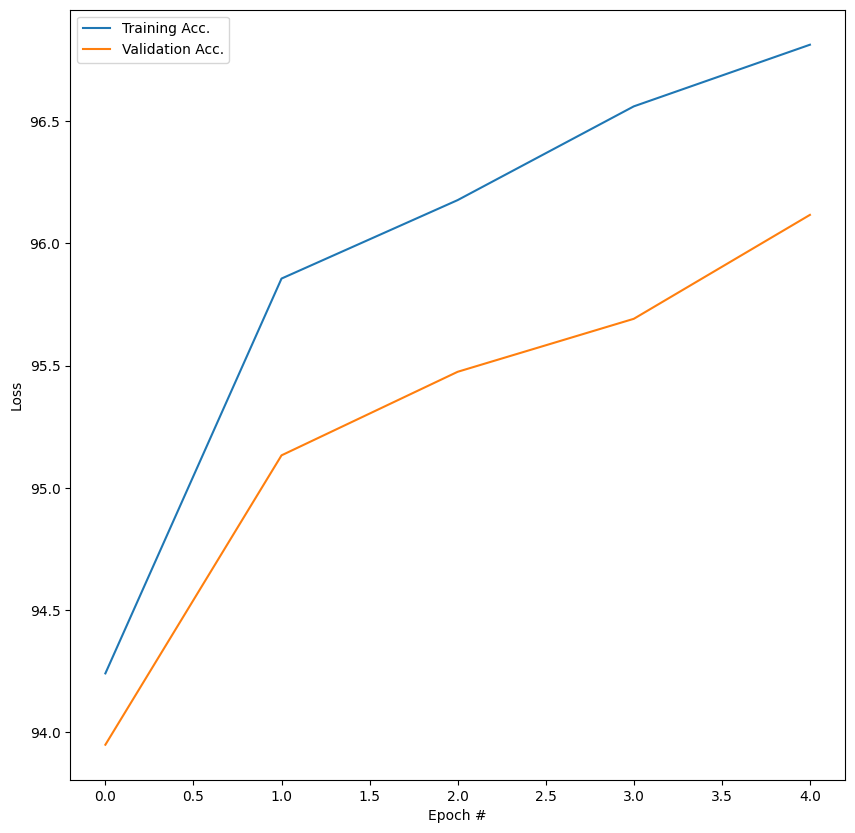

In [102]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(nonlinear_model.parameters(), lr=5e-3)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### NADAM (Nesterov Adam Optimizer)

Epoch 0: training loss: 0.17567705462872982, accuracy: 94.79166666666666
Epoch 0: val. loss: 0.17946087920721224, val. accuracy: 94.68333333333334
Epoch 1: training loss: 0.12479461918895443, accuracy: 96.21666666666667
Epoch 1: val. loss: 0.1412964168975645, val. accuracy: 95.69166666666666
Epoch 2: training loss: 0.10878517940143743, accuracy: 96.78750000000001
Epoch 2: val. loss: 0.1299905407841892, val. accuracy: 96.14166666666667
Epoch 3: training loss: 0.09113393833550314, accuracy: 97.26458333333333
Epoch 3: val. loss: 0.1202732909649135, val. accuracy: 96.55
Epoch 4: training loss: 0.08986878741718829, accuracy: 97.29583333333333
Epoch 4: val. loss: 0.1226110332546399, val. accuracy: 96.275


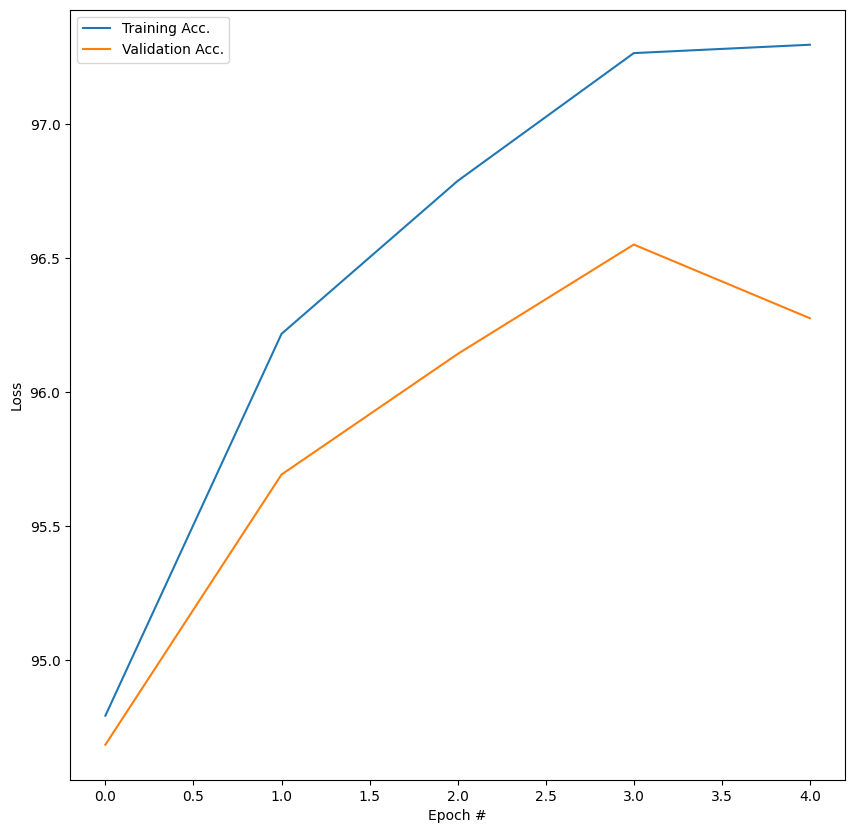

In [103]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(nonlinear_model.parameters(), lr=5e-3)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

### RMSProp Optimizer (Cheers to Geoff Hinton for winning the Nobel!)

Epoch 0: training loss: 0.24949253523349763, accuracy: 92.77708333333334
Epoch 0: val. loss: 0.25193459859633066, val. accuracy: 92.59166666666667
Epoch 1: training loss: 0.2199657637824615, accuracy: 93.40625
Epoch 1: val. loss: 0.2279770516176173, val. accuracy: 93.27499999999999
Epoch 2: training loss: 0.1799102509667476, accuracy: 94.68541666666667
Epoch 2: val. loss: 0.20161690202323682, val. accuracy: 94.09166666666667
Epoch 3: training loss: 0.1607984027589361, accuracy: 95.21666666666667
Epoch 3: val. loss: 0.1794681377966512, val. accuracy: 94.66666666666667
Epoch 4: training loss: 0.15864853075395027, accuracy: 95.29791666666667
Epoch 4: val. loss: 0.1838818397472038, val. accuracy: 94.31666666666668


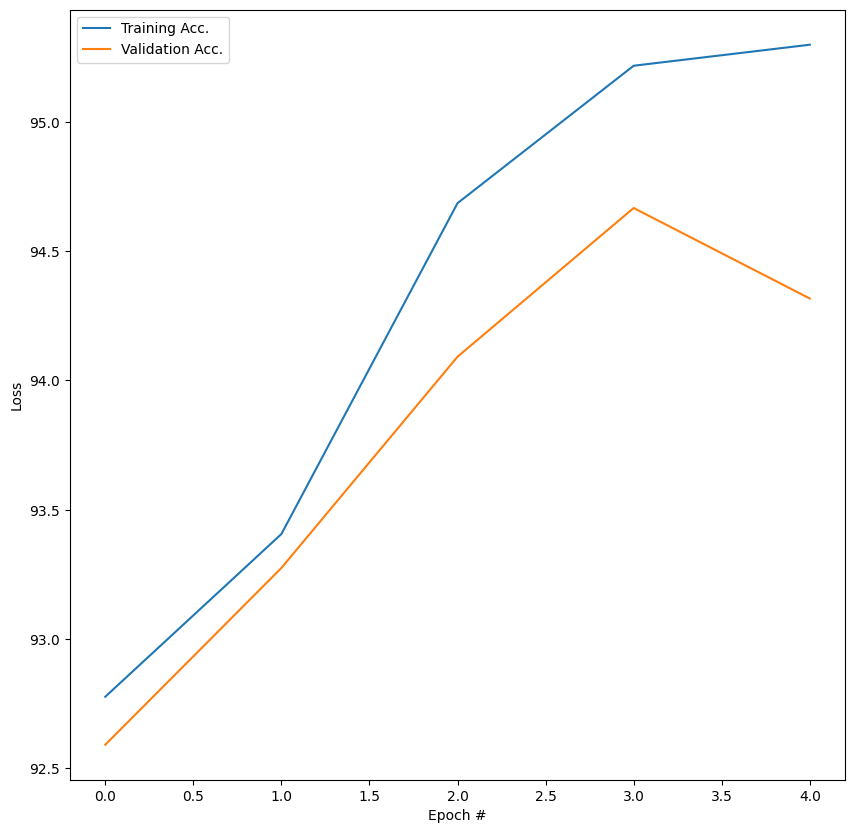

In [104]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(nonlinear_model.parameters(), lr=5e-3)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)

Epoch 0: training loss: 0.1836802632510662, accuracy: 94.46666666666667
Epoch 0: val. loss: 0.19203421810364468, val. accuracy: 94.23333333333333
Epoch 1: training loss: 0.13130057144910098, accuracy: 96.08333333333333
Epoch 1: val. loss: 0.1537145567572418, val. accuracy: 95.53333333333333
Epoch 2: training loss: 0.11699918924023708, accuracy: 96.42500000000001
Epoch 2: val. loss: 0.1418476001844999, val. accuracy: 95.71666666666667
Epoch 3: training loss: 0.10032917491036157, accuracy: 96.9375
Epoch 3: val. loss: 0.12740254502104437, val. accuracy: 96.14166666666667
Epoch 4: training loss: 0.099168121719112, accuracy: 97.01458333333333
Epoch 4: val. loss: 0.12648987915723564, val. accuracy: 96.38333333333333


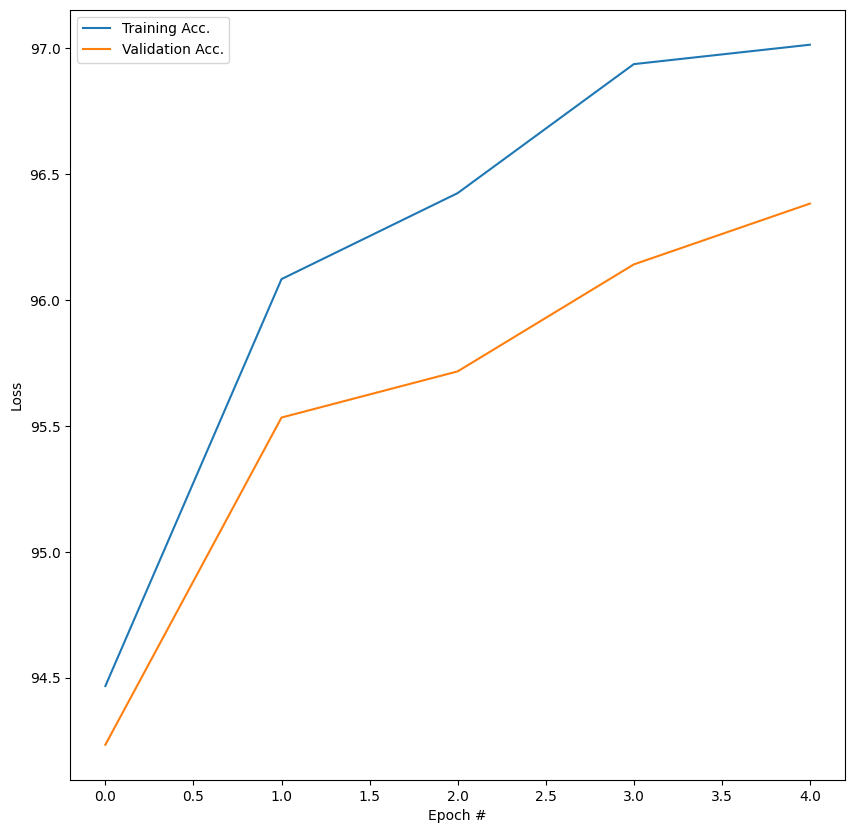

In [106]:
batch_size = 64
epochs = 5

train_dataloader, val_dataloader = get_dataloaders(training_data, validation_data, batch_size)
nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(nonlinear_model.parameters(), lr=5e-3)

train_acc_all, val_acc_all = train_model(epochs, train_dataloader, val_dataloader, nonlinear_model, loss_fn, optimizer)
plot_training_run(train_acc_all, val_acc_all)
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)

In [107]:
print(acc_test, loss_test)

96.23 0.11993512046756223


# Verdict:

We find the following configuration to be optimal among those we have explored in this analysis.

* Optimizer: NAdam
* Learning rate: 5e-3
* Batch size: 64

Final test accuracy: 96.23%